In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from jellyfish import jaro_winkler_similarity, levenshtein_distance
import numpy as np
import matplotlib.pyplot as plt

## Functions used for calculating metrics

In [2]:
def calculate_cosine_similarity(correct_words, corrected_words):
    vectorizer = TfidfVectorizer().fit(correct_words + corrected_words)
    correct_vectors = vectorizer.transform(correct_words).toarray()
    corrected_vectors = vectorizer.transform(corrected_words).toarray()
    
    similarities = []
    for i in range(len(correct_words)):
        if np.any(correct_vectors[i]) and np.any(corrected_vectors[i]):
            similarity = 1 - cosine(correct_vectors[i], corrected_vectors[i])
            similarities.append(similarity)
        else:
            similarities.append(np.nan) 
    
    return similarities

def calculate_jaro_winkler(correct_words, corrected_words):
    return [jaro_winkler_similarity(cw, ccw) for cw, ccw in zip(correct_words, corrected_words)]

def calculate_levenshtein(correct_words, corrected_words):
    return [levenshtein_distance(cw, ccw) for cw, ccw in zip(correct_words, corrected_words)]

def calculate_accuracy(correct_words, corrected_words):
    return accuracy_score(correct_words, corrected_words)

## Calculating metrics for each dataset and each correction approach

In [3]:
models = ['symspell_correction', 'bert_correction', 'lstm_cnn_correction']
files = ["words_corrected/small_typo_errors_lowercase_corrected.csv", "words_corrected/transposition_errors_lowercase_corrected.csv",  "words_corrected/fonetic_errors_lowercase_corrected.csv", "words_corrected/other_errors_lowercase_corrected.csv"]
results = {}

for file in files:
    df = pd.read_csv(file)
    file_results = {}
    
    for model in models:
        correct_words = df['correct_spelling'].astype(str).tolist()
        corrected_words = df[model].astype(str).tolist()
    
        cosine_similarities = calculate_cosine_similarity(correct_words, corrected_words)
        jaro_winkler_similarities = calculate_jaro_winkler(correct_words, corrected_words)
        levenshtein_distances = calculate_levenshtein(correct_words, corrected_words)
        accuracy = calculate_accuracy(correct_words, corrected_words)
    
        file_results[model] = {
            'Average Cosine Similarity': np.nanmean(cosine_similarities),
            'Average Jaro-Winkler Similarity': np.mean(jaro_winkler_similarities),
            'Average Levenshtein Distance': np.mean(levenshtein_distances),
            'Accuracy': accuracy,
        }
        
    results[file] = file_results

## Plotting the results

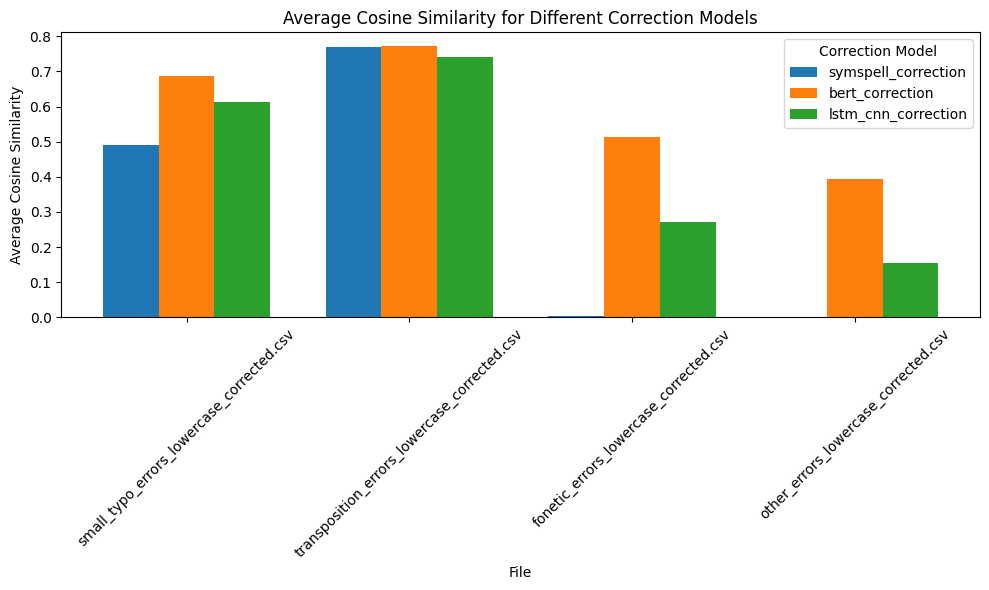

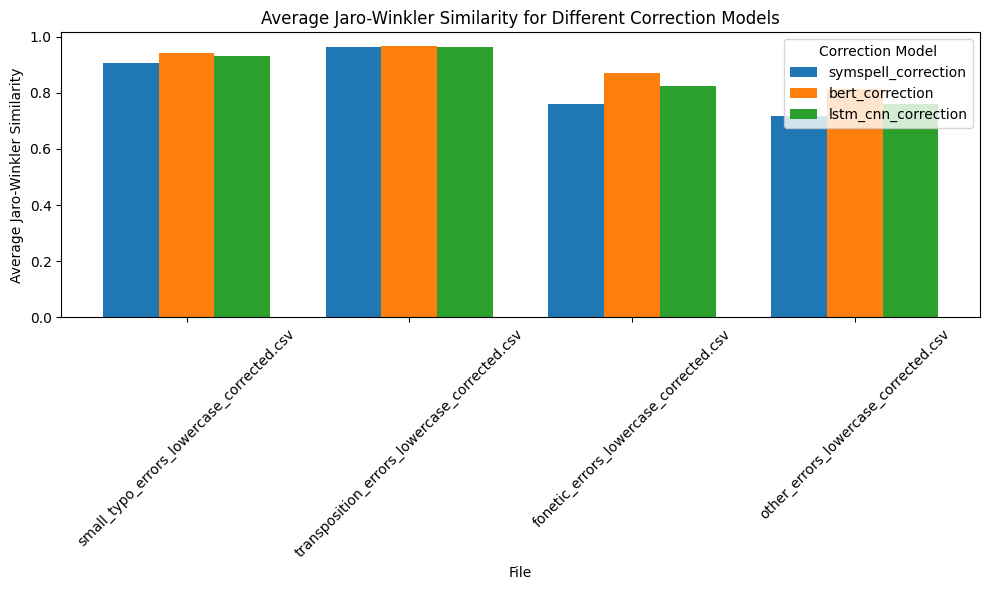

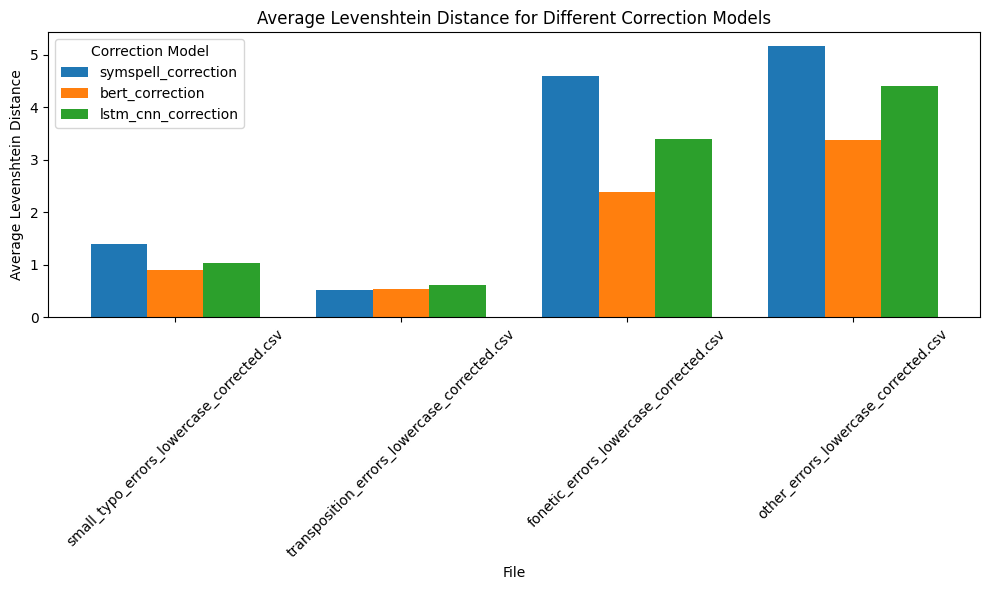

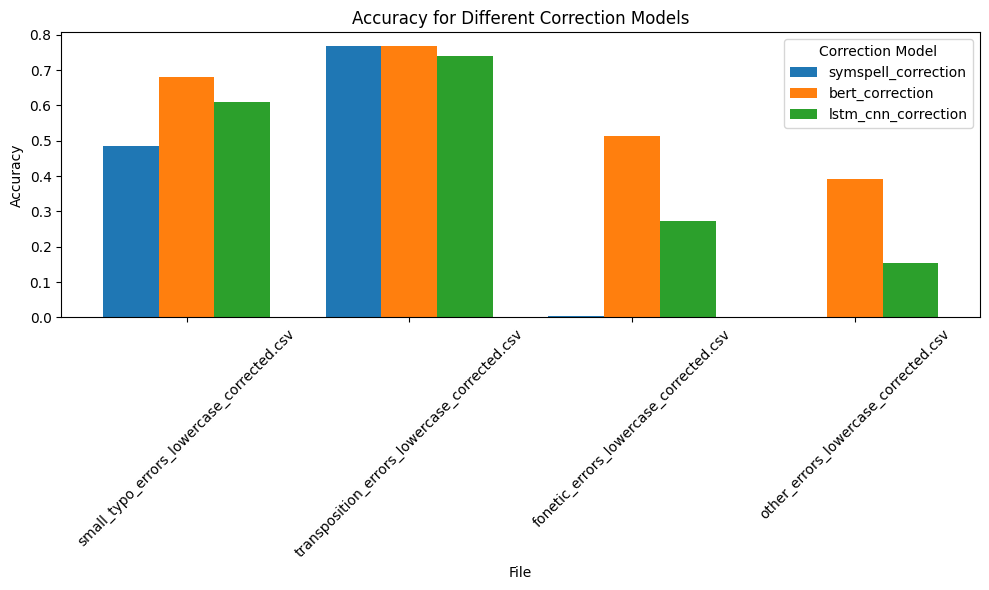

In [4]:
metrics = ['Average Cosine Similarity', 'Average Jaro-Winkler Similarity', 'Average Levenshtein Distance', 'Accuracy']
for metric in metrics:
    labels = [file[5:] for file in files] 
    x = np.arange(len(labels))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, model in enumerate(models):
        metric_values = [results[file][model][metric] for file in files]
        ax.bar(x + i * width, metric_values, width, label=model)
    
    ax.set_xlabel('File')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} for Different Correction Models')
    ax.set_xticks(x + width)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend(title="Correction Model")
    
    plt.tight_layout()
    plt.show()

In [5]:
def calculate_jaccard_similarity(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def calculate_levenshtein(text1, text2):
    return levenshtein_distance(text1, text2)

In [6]:
results = {model: {'Levenshtein Distance': [], 'Jaccard-Similarity': []} 
           for model in ['symspell_correction', 'bert_correction', 'lstm_cnn_correction']}

In [7]:
df = pd.read_csv("articles_corrected/articles_augmented_corrected.csv")
for index, row in df.iterrows():
    correct_text = row['correct_text']
    for model in models:
        corrected_text = row[model]
        
        lev_dist = calculate_levenshtein(correct_text, corrected_text)
        results[model]['Levenshtein Distance'].append(lev_dist)
        
        jaccard_sim = calculate_jaccard_similarity(correct_text, corrected_text)
        results[model]['Jaccard-Similarity'].append(jaccard_sim)

for model, metrics in results.items():
    print(f"\nMetrics for {model}:")
    for metric, values in metrics.items():
        print(f"{metric}: {np.mean(values):.4f}")


Metrics for symspell_correction:
Levenshtein Distance: 1297.7400
Jaccard-Similarity: 0.3986

Metrics for bert_correction:
Levenshtein Distance: 9890.8000
Jaccard-Similarity: 0.1422

Metrics for lstm_cnn_correction:
Levenshtein Distance: 1053.5400
Jaccard-Similarity: 0.4728
